# NARX GP Grid Search

In [1]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from matplotlib import pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, RationalQuadratic, Product

from scipy.sparse import csr_matrix

from data import load_narx_data, load_data
from util_fun import calculate_error_nrms, use_NARX_model_in_simulation, plot_NRMS_Pred_vs_Sim

### Chang settings for gridsearch here

In [2]:
# Initialize stationary parameters

Split = [0.6, 0.2, 0.2] # split; [training, validation, test]
total_number_of_points = 300 # total number of points to consider from the larger dataset (starting from index 0)

na_list=[*range(2,11)]
nb_list=[*range(2,6)]
restarts = 0

val_pred_NRMSs=np.ndarray((len(na_list),len(nb_list)))
val_sim_NRMSs=np.ndarray((len(na_list),len(nb_list)))
test_pred_NRMSs=np.ndarray((len(na_list),len(nb_list)))
test_sim_NRMSs=np.ndarray((len(na_list),len(nb_list)))

## Define your kernel here

In [3]:
kernel = RBF(length_scale_bounds=[1e-2,1e2]) + WhiteKernel(noise_level_bounds=[1e-10,1e3])
reg = GaussianProcessRegressor(kernel, n_restarts_optimizer=restarts)

In [4]:
#Load normal data
Xtrain,Ytrain = load_data(section="train", split=Split, total_number_of_points=total_number_of_points, as_tensor=False)
Xval,Yval = load_data(section="validation", split=Split, total_number_of_points=total_number_of_points, as_tensor=False)
Xtest,Ytest = load_data(section="test", split=Split, total_number_of_points=total_number_of_points, as_tensor=False)

Using 180 datapoints for training set


In [5]:
for i, n_a in enumerate(na_list):
    for j, n_b in enumerate(nb_list):
        
        print(f"Currently running: na= {n_a}, nb= {n_b}")
        
        #Construct NARX data
        Xtrain_NARX,Ytrain_NARX = load_narx_data(n_a, n_b, total_number_of_points, section="train", split=Split, as_tensor=False)
        Xval_NARX,Yval_NARX = load_narx_data(n_a, n_b, total_number_of_points, section="validation", split=Split, as_tensor=False)
        Xtest_NARX,Ytest_NARX = load_narx_data(n_a, n_b, total_number_of_points, section="test", split=Split, as_tensor=False)
        

        #Convert to sparce matrices
        XtrainSparse = csr_matrix(Xtrain_NARX).toarray()
        YtrainSparse = csr_matrix(Ytrain_NARX).toarray().transpose()

        #Fit the GP
        reg.fit(XtrainSparse, YtrainSparse)
        print(reg.kernel_)
        
        #Initialize parameters for simulation
        fmodel = lambda u,y: reg.predict(np.concatenate([u,y])[None,:])[0] 
        
        #Prediction on validation set
        Yval_pred, Yval_pred_std = reg.predict(Xval_NARX,return_std=True)
        
        #Simulation on validation set
        Yval_sim = use_NARX_model_in_simulation(Xval, fmodel, n_a, n_b)
        
        #Prediction on test set
        Ytest_pred, Ytest_pred_std = reg.predict(Xtest_NARX,return_std=True)
        
        #Simulation on test set
        Ytest_sim = use_NARX_model_in_simulation(Xtest, fmodel, n_a, n_b)
        
        #Store results
        val_pred_NRMSs[i,j] = calculate_error_nrms(Yval_pred, Yval_NARX)
        val_sim_NRMSs[i,j] = calculate_error_nrms(Yval_sim, Yval)
        test_pred_NRMSs[i,j] = calculate_error_nrms(Ytest_pred, Ytest_NARX)
        test_sim_NRMSs[i,j] = calculate_error_nrms(Ytest_sim, Ytest)

Currently running: na= 2, nb= 2
Using 180 datapoints for training set
RBF(length_scale=3.97) + WhiteKernel(noise_level=1.02e-05)
Currently running: na= 2, nb= 3
Using 180 datapoints for training set
RBF(length_scale=5.6) + WhiteKernel(noise_level=1.61e-05)
Currently running: na= 2, nb= 4
Using 180 datapoints for training set
RBF(length_scale=6.82) + WhiteKernel(noise_level=1.75e-05)
Currently running: na= 2, nb= 5
Using 180 datapoints for training set
RBF(length_scale=7.5) + WhiteKernel(noise_level=1.54e-05)
Currently running: na= 3, nb= 2
Using 180 datapoints for training set
RBF(length_scale=4.47) + WhiteKernel(noise_level=9.93e-06)
Currently running: na= 3, nb= 3
Using 180 datapoints for training set
RBF(length_scale=7.11) + WhiteKernel(noise_level=1.4e-05)
Currently running: na= 3, nb= 4
Using 180 datapoints for training set
RBF(length_scale=9.05) + WhiteKernel(noise_level=1.56e-05)
Currently running: na= 3, nb= 5
Using 180 datapoints for training set
RBF(length_scale=10) + WhiteKe

# Validation data

c:\Users\20191695\Desktop\TUe\Master\Year1\Q4\5SC28\5SC28\util_fun.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels([0]+na_list)
c:\Users\20191695\Desktop\TUe\Master\Year1\Q4\5SC28\5SC28\util_fun.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels([0]+na_list)


Best parameters by prediction NRMS: na= 6, nb= 2
Best parameters by simulation NRMS: na= 2, nb= 2


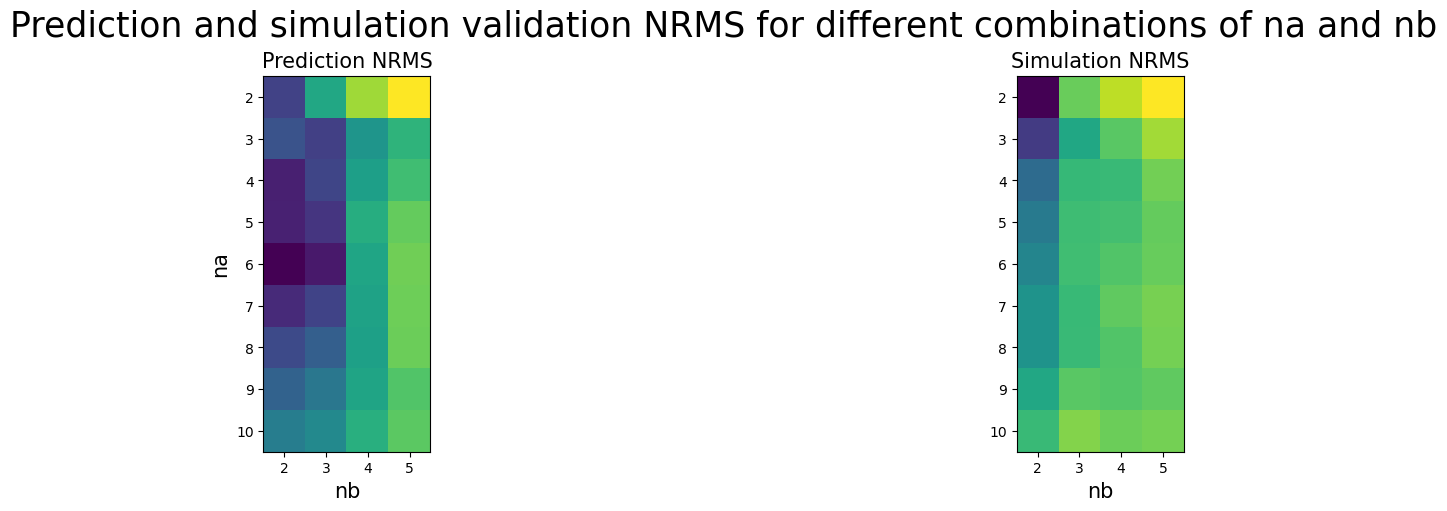

In [6]:
best_na_nb_val_pred, best_na_nb_val_sim = plot_NRMS_Pred_vs_Sim(val_pred_NRMSs, val_sim_NRMSs, na_list, nb_list)

# Test data

Best parameters by prediction NRMS: na= 5, nb= 2
Best parameters by simulation NRMS: na= 6, nb= 2


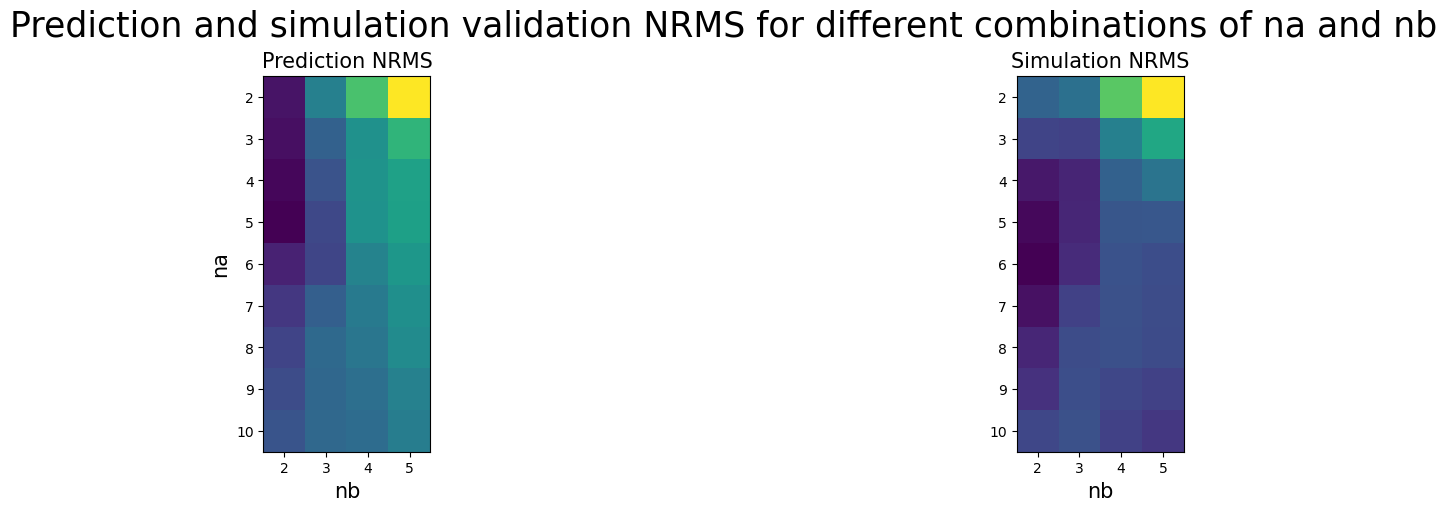

In [7]:
best_na_nb_test_pred, best_na_nb_test_sim = plot_NRMS_Pred_vs_Sim(test_pred_NRMSs, test_sim_NRMSs, na_list, nb_list)

In [8]:
print(f"Best test prediction NRMS found: {test_pred_NRMSs.min()}")
print(f"Best test simulation NRMS found: {test_sim_NRMSs.min()}")

Best test prediction NRMS found: 1.1902366553301469
Best test simulation NRMS found: 14.288884923106204


# Run best na and nb again on larger dataset

### Change settings for optimization

In [9]:
n_a, n_b = best_na_nb_val_sim
Split = [0.6, 0.2, 0.2] # split; [training, validation, test]
total_number_of_points = [1000, 3000, 5000, 10000] # total number of points to consider from the larger dataset (starting from index 0)
restart = [1,5,10]

In [10]:
print('Going to use na={} and nb={}'.format(n_a,n_b))

Going to use na=2 and nb=2


In [11]:
NRMS_train_pred = np.ndarray((len(total_number_of_points),len(restart)))
NRMS_train_sim = np.ndarray((len(total_number_of_points),len(restart)))
NRMS_val_pred = np.ndarray((len(total_number_of_points),len(restart)))
NRMS_val_sim = np.ndarray((len(total_number_of_points),len(restart)))
NRMS_test_pred = np.ndarray((len(total_number_of_points),len(restart)))
NRMS_test_sim = np.ndarray((len(total_number_of_points),len(restart)))

In [12]:
for i,points in enumerate(total_number_of_points):
    for j,res in enumerate(restart):

        Xtrain_NARX, Ytrain_NARX = load_narx_data(n_a, n_b, points, section="train", split=Split, as_tensor=False)
        Xval_NARX, Yval_NARX = load_narx_data(n_a, n_b, points, section="validation", split=Split, as_tensor=False)
        Xtest_NARX, Ytest_NARX = load_narx_data(n_a, n_b, points, section="test", split=Split, as_tensor=False)

        XtrainNARXSparse = csr_matrix(Xtrain_NARX).toarray()
        YtrainNARXSparse = csr_matrix(Ytrain_NARX).toarray().transpose()

        kernel = RBF(length_scale_bounds=[1,50]) + WhiteKernel(noise_level_bounds=[1e-6,1e-2])
        # kernel = RationalQuadratic() + WhiteKernel()
        reg = GaussianProcessRegressor(kernel, n_restarts_optimizer=res)

        reg.fit(XtrainNARXSparse, YtrainNARXSparse)

        print(reg.kernel_)

        Ytrain_pred, Ytrain_pred_std = reg.predict(Xtrain_NARX,return_std=True)
        NRMS_train_pred[i,j] = calculate_error_nrms(Ytrain_pred, Ytrain_NARX)
        print(f'Train prediction NRMS: {NRMS_train_pred[i,j]:.2f} %')

        Yval_pred, Yval_pred_std = reg.predict(Xval_NARX,return_std=True)
        NRMS_val_pred[i,j] = calculate_error_nrms(Yval_pred, Yval_NARX)
        print(f'Validation prediction NRMS: {NRMS_val_pred[i,j]:.2f} %')

        Ytest_pred, Ytest_pred_std = reg.predict(Xtest_NARX,return_std=True)
        NRMS_test_pred[i,j] = calculate_error_nrms(Ytest_pred, Ytest_NARX)
        print(f'Test prediction NRMS: {NRMS_test_pred[i,j]:.2f} %')


        # Simulation
        Xtrain,Ytrain = load_data(section="train", split=Split, total_number_of_points=points, as_tensor=False)
        Xval,Yval = load_data(section="validation", split=Split, total_number_of_points=points, as_tensor=False)
        Xtest,Ytest = load_data(section="test", split=Split, total_number_of_points=points, as_tensor=False)

        sim_model = lambda u,y: reg.predict(np.concatenate([u,y])[None,:])[0] 

        Ytrain_sim = use_NARX_model_in_simulation(Xtrain, sim_model, n_a, n_b)
        NRMS_train_sim[i,j] = calculate_error_nrms(Ytrain_sim, Ytrain)
        print(f'Train simulation NRMS: {NRMS_train_sim[i,j]:.2f} %')

        Yval_sim = use_NARX_model_in_simulation(Xval, sim_model, n_a, n_b)
        NRMS_val_sim[i,j] = calculate_error_nrms(Yval_sim, Yval)
        print(f'Validation simulation NRMS: {NRMS_val_sim[i,j]:.2f} %')

        Ytest_sim = use_NARX_model_in_simulation(Xtest, sim_model, n_a, n_b)
        NRMS_test_sim[i,j] = calculate_error_nrms(Ytest_sim, Ytest)
        print(f'Test simulation NRMS: {NRMS_test_sim[i,j]:.2f} %')

Using 600 datapoints for training set
RBF(length_scale=4.33) + WhiteKernel(noise_level=1.19e-05)
Train prediction NRMS: 0.94 %
Validation prediction NRMS: 1.49 %
Test prediction NRMS: 0.94 %
Using 600 datapoints for training set
Train simulation NRMS: 9.18 %
Validation simulation NRMS: 33.72 %
Test simulation NRMS: 20.85 %
Using 600 datapoints for training set
RBF(length_scale=4.33) + WhiteKernel(noise_level=1.19e-05)
Train prediction NRMS: 0.94 %
Validation prediction NRMS: 1.49 %
Test prediction NRMS: 0.94 %
Using 600 datapoints for training set
Train simulation NRMS: 9.18 %
Validation simulation NRMS: 33.72 %
Test simulation NRMS: 20.85 %
Using 600 datapoints for training set
RBF(length_scale=4.33) + WhiteKernel(noise_level=1.19e-05)
Train prediction NRMS: 0.94 %
Validation prediction NRMS: 1.49 %
Test prediction NRMS: 0.94 %
Using 600 datapoints for training set
Train simulation NRMS: 9.18 %
Validation simulation NRMS: 33.72 %
Test simulation NRMS: 20.85 %
Using 1800 datapoints for

## Final results

In [ ]:
# Create empty DataFrames
df_pred = pd.DataFrame(columns=['Train', 'Validation', 'Test'])
df_sim = pd.DataFrame(columns=['Train', 'Validation', 'Test'])

# Fill DataFrames with Pred and Sim data
df_pred['Train'] = NRMS_train_pred.ravel()
df_pred['Validation'] = NRMS_val_pred.ravel()
df_pred['Test'] = NRMS_test_pred.ravel()

df_sim['Train'] = NRMS_train_sim.ravel()
df_sim['Validation'] = NRMS_val_sim.ravel()
df_sim['Test'] = NRMS_test_sim.ravel()

# Create the index
index = ['{} points; {} restarts'.format(points, res) for points in total_number_of_points for res in restart]

# Concatenate DataFrames horizontally
df_combined = pd.concat([df_pred, df_sim], axis=1, keys=['Pred', 'Sim'])

# Set the index
df_combined.index = index

# Display the DataFrame
display(df_combined)
